# Daymat Gi Ploermel - Scraping + Analysis

Playing with Selenium this time to scrape the <a href='https://smoothcomp.com/en/event/13400'>Smoothcomp page</a> of the Daymat BJJ competition (Ploermel, Nov 2023). Pretty crude attempt that would need to be refined quite a bit. Still, it gets the job done.

**<a name='0'>Table of contents</a>**

1. <a href='#1'>Importing libraries</a>
2. <a href='#2'>Scrape the participants data ahead of the competition</a>
    * <a href='#21'>2.1. Scraping function</a>
    * <a href='#22'>2.2. Gi data</a>
    * <a href='#23'>2.3. No gi data</a>
    * <a href='#24'>2.4. Build and save dataframe</a>
    * <a href='#25'>2.5. Visualisations</a>

## 1. <a name='1'>Importing libraries</a>
(<a href='#0'>Go to top</a>)

In [1]:
import os
import requests
import re
from bs4 import BeautifulSoup
import selenium.webdriver as webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager # conda install -c conda-forge webdriver-manager
from webdriver_manager.firefox import GeckoDriverManager
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

## 2. <a name='2'>Scrape the participants data ahead of the competition</a>
(<a href='#0'>Go to top</a>)

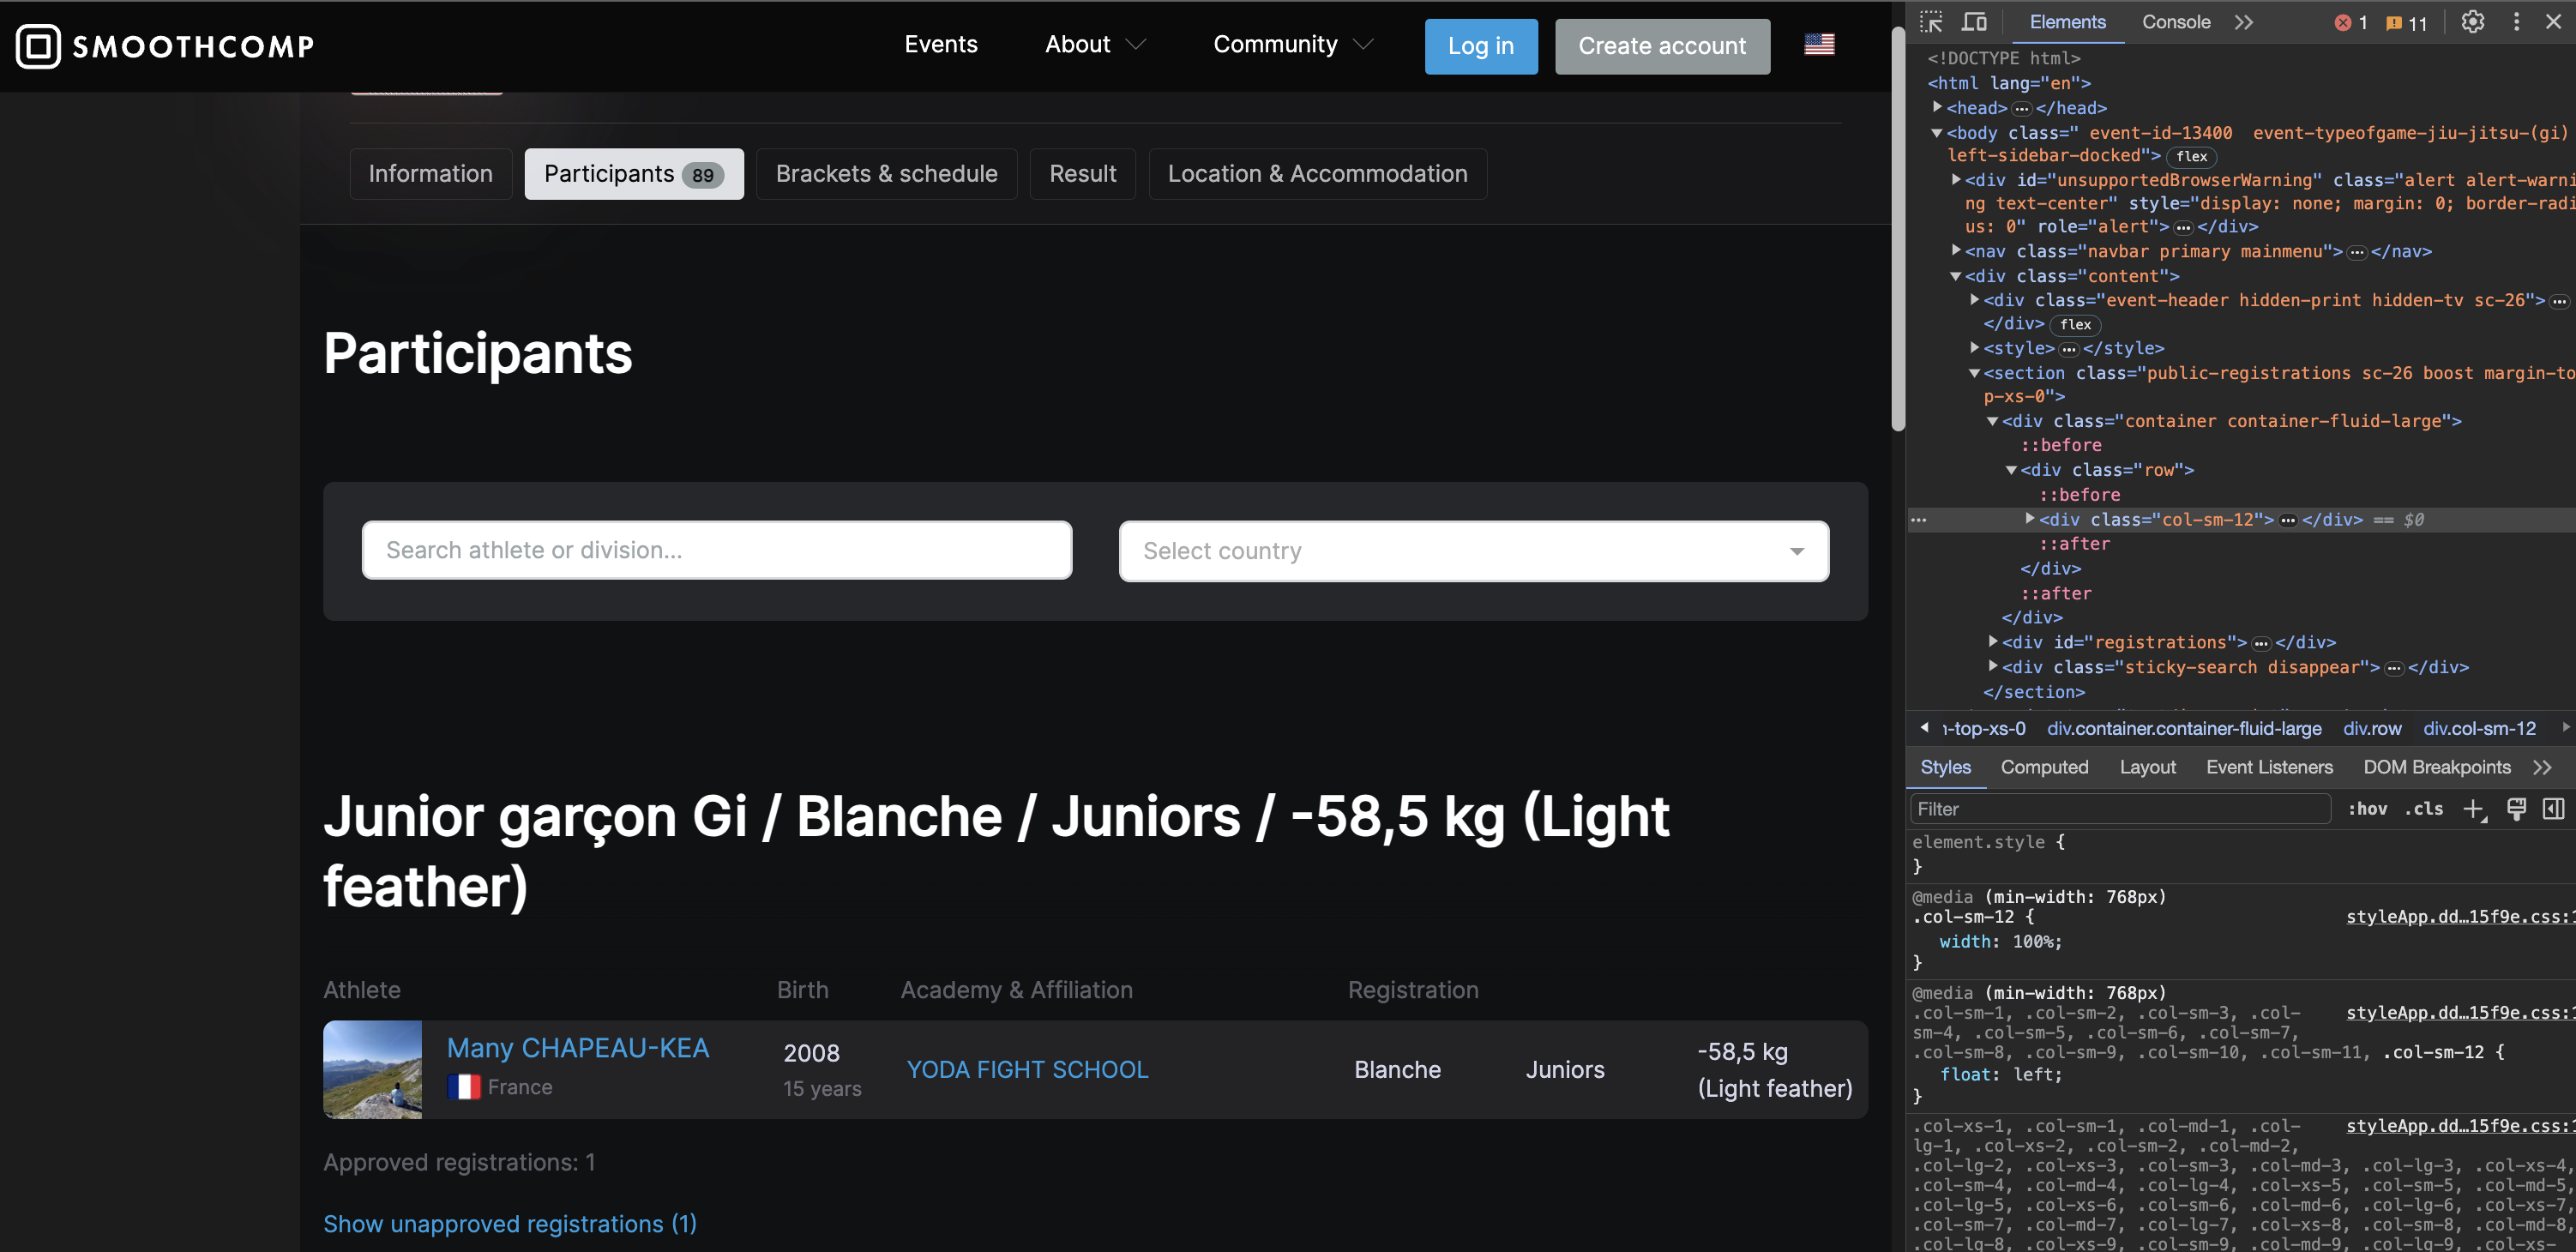

### 2.1. <a name='21'>Scraping function</a>
(<a href='#0'>Go to top</a>)

Looks like the .html I get from BeautifulSoup doesn't match the .html that I can see when I inspect the page. My guess is that requests does not actually run the .js scripts on the page.

In [2]:
url = 'https://smoothcomp.com/en/event/13400/participants'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
print(soup)

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>
                  Participants - Daymat GI - Smoothcomp
              </title>
<meta content="" name="author"/>
<meta content="FFilPG0PkxyPucipqzfQ7joYlzJ9VmX6HeC0HPGM" name="csrf-token"/>
<link href="https://smoothcomp.com/en/event/13400/participants" hreflang="en" rel="alternate"/>
<link href="https://smoothcomp.com/pt_BR/event/13400/participants" hreflang="pt_BR" rel="alternate"/>
<link href="https://smoothcomp.com/es/event/13400/participants" hreflang="es" rel="alternate"/>
<link href="https://smoothcomp.com/jp/event/13400/participants" hreflang="jp" rel="alternate"/>
<link href="https://smoothcomp.com/fr/event/13400/participants" hreflang="fr" rel="alternate"/>
<link href="https://smoothcomp.com/it/event/13400/participants" hreflang="it" rel="alternate"/>
<link href="https://smoothcomp.

Let's try selenium. We also need webdriver_manager. Tricky thing here is that you need to scroll the page little by little to reveal the whole page.

In [3]:
def scrape(url):

    driver = webdriver.Firefox(service = Service(GeckoDriverManager().install()))
    driver.maximize_window()
    driver.get(url)

    # to scroll all the way to the bottom of the page as not everything gets loaded from the get go (from: https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python)
    scroll_pause_time = 0.5
    last_height = driver.execute_script('return document.body.scrollHeight') # get scroll height
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);') # scroll to bottom
        time.sleep(scroll_pause_time) # wait to load page
        new_height = driver.execute_script('return document.body.scrollHeight') # calculate new scroll height and compare with last scroll height
        if new_height == last_height:
            break
        last_height = new_height

    cat_list = []
    i = 1
    # try to read each category until we have no category left and we get an error
    while True:
        try:
            category = (WebDriverWait(driver, 10)
                        .until(EC.presence_of_element_located((By.XPATH, f'/html/body/div[2]/section/div[2]/div[2]/div[{i}]'))))
            cat_list.append(category.text)
        except:
            break
        i = i + 1
    # release the resources allocated by selenium and shut down the browser
    driver.quit()
    
    return(cat_list)

### 2.2. <a name='22'>Gi data</a>
(<a href='#0'>Go to top</a>)

In [63]:
url = 'https://smoothcomp.com/en/event/13400/participants'
gi_list = scrape(url)

In [64]:
gi_list[0].split('\n')

['Junior garçon Gi / Blanche / Juniors / -58,5 kg (Light feather)',
 'Athlete',
 'Birth',
 'Academy & Affiliation',
 'Registration',
 'Many CHAPEAU-KEA',
 'France',
 '2008',
 '15 years',
 'YODA FIGHT SCHOOL',
 'Blanche',
 'Juniors',
 '-58,5 kg (Light feather)',
 'Alex Clément',
 'France',
 '2007',
 '16 years',
 'MKTEAM RENNES',
 'Blanche',
 'Juniors',
 '-58,5 kg (Light feather)',
 'Approved registrations: 2']

### 2.3. <a name='23'>No gi data</a>
(<a href='#0'>Go to top</a>)

In [65]:
url = 'https://smoothcomp.com/en/event/13433/participants'
nogi_list = scrape(url)

In [66]:
nogi_list[0].split('\n')

['Junior Garçon No-Gi / Blanche / Junior No Gi / -56,5 kg (Light feather)',
 'Bracket',
 'Athlete',
 'Birth',
 'Academy & Affiliation',
 'Registration',
 'Many CHAPEAU-KEA',
 'France',
 '2008',
 '15 years',
 'YODA FIGHT SCHOOL',
 'Blanche',
 'Junior No Gi',
 '-56,5 kg (Light feather)',
 'Lilian Loriot',
 'France',
 '2008',
 '15 years',
 'Monkey gym',
 'Blanche',
 'Junior No Gi',
 '-56,5 kg (Light feather)',
 'Approved registrations: 2']

### 2.4. <a name='24'>Build and save dataframe</a>
(<a href='#0'>Go to top</a>)

In [189]:
def structure_data(cat_list, comp_type):

    df = pd.DataFrame()
    df_dict = {}

    for n in range(len(cat_list)):

        cat_data = cat_list[n].split('\n')
        
        # getting rid of substrings that add annoying elements in cat_data (will need to find a smarter way to deal with this)
        for string in ['certif ok'
                       , 'Certif OK'
                       , 'Certif ok'
                       , 'avec les adultes ? Certif OK'
                       , 'j\'essaye de faire venir les master avec vous 2'
                       , 'avec les adultes pour avoir 3 combats ?'
                       , 'en master 1 ?'
                       , 'avec les autres juniors en bleue/blanc ?'
                       , 'avec thomas en master 1 ?'
                       , 'avec les autres - 76 plus jeunes ?'
                       , 'avec Thomas en master 1 ?'
                       , 'quel poids exactement ?'
                       , 'avec les - 73 master 1 ?'
                       , 'avec William en master 2 ?'
                       , 'avec Mathieu en Master 2 (1 combats) ou en adultes et beaucoup de combats !'
                       , 'avec Yvonnick en master 2 ? voir même tous les master - 70 ensemble'
                       , 'avec les adultes ?'
                       , 'avec les adultes avec une décharge des parents'
                       , 'partenaire de Titouan'
                       , 'avec les master 1 ?'
                       , 'j\'ai Xavier de ton âge mais 95 kg'
                       , 'avec le - 56 ?'
                       , 'avec les - 61 adultes si décharde signée des parents ?'
                       , 'quel poids exactement ?'
                       , '75 kg'
                       , 'avec les noires si accord ?'
                       , 'violette'
                       , 'Nellys Tonco, certif ok'
                       , 'Bracket'
                       , 'Ribeiro Jiujitsu'
                      ]: 
        
            while True: # loop because might need to remove it multiple times
                try:
                    cat_data.remove(string)
                except ValueError:
                    break
        
        fighter_list = []
        country_list = []
        age_list = []
        team_list = []

        cat_name = cat_data[0].lower()
        app_reg_count = int([item for item in cat_data if item.startswith('Approved registrations')][0].split(': ')[- 1])
        try:
            una_reg_count = int([item for item in cat_data if item.startswith('Show unapproved registrations')][0].split('(')[- 1].replace(')', ''))
        except IndexError:
            una_reg_count = 0

        for k in range(app_reg_count):
            fighter_list.append(cat_data[5 + (8 * k)].lower())
            country_list.append(cat_data[6 + (8 * k)].lower())
            # if missing age then null
            try:
                age_list.append(int(cat_data[8 + (8 * k)].split(' years')[0]))
            except ValueError: 
                age_list.append(np.nan)                
            team_list.append(cat_data[9 + (8 * k)].lower())
        df_dict[n] = pd.DataFrame(data = {'nom': fighter_list
                                          , 'pays': country_list
                                          , 'age': age_list
                                          , 'team': team_list
                                         }
                                 )
        
        if 'garçon' in cat_name.split(' / ')[0]:
            gender = 'homme'
        elif 'homme' in cat_name.split(' / ')[0]:
            gender = 'homme'
        else:
            gender = 'femme'
        
        if cat_name.split(' / ')[1].strip() == 'white':
            belt = 'blanche'
        elif cat_name.split(' / ')[1].strip() == 'blue':
            belt = 'bleue'
        elif cat_name.split(' / ')[1].strip() == 'purple':
            belt = 'violette'
        elif cat_name.split(' / ')[1].strip() == 'brown/black':
            belt = 'marron/noire'
        else:
            belt = cat_name.split(' / ')[1].strip()
        
        age_group = cat_name.split(' / ')[2].strip()
        weight_class = cat_name.split(' / ')[3].strip()

        # if missing age then need default team name (will need to find a way to deal with this)
        df_dict[n]['team'] = np.where(df_dict[n]['age'].isna(), 'unknown', df_dict[n]['team'])
        df_dict[n]['sexe'] = gender
        df_dict[n]['ceinture'] = belt
        df_dict[n]['groupe_age'] = age_group
        df_dict[n]['groupe_poids'] = weight_class
        df_dict[n]['categorie'] = cat_name
        df_dict[n]['inscriptions_cate_confirmees'] = app_reg_count
        df_dict[n]['inscriptions_cate_nonconfirmees'] = una_reg_count
        df_dict[n]['type'] = comp_type
        df_dict[n]['snapshot_date'] = pd.to_datetime('today').strftime('%Y-%m-%d')

        df = pd.concat([df, df_dict[n]])
        df.reset_index()

    del df_dict[n]
    
    return(df)

Annoying case without age that we would need to deal with more gracefully than what I have done above:

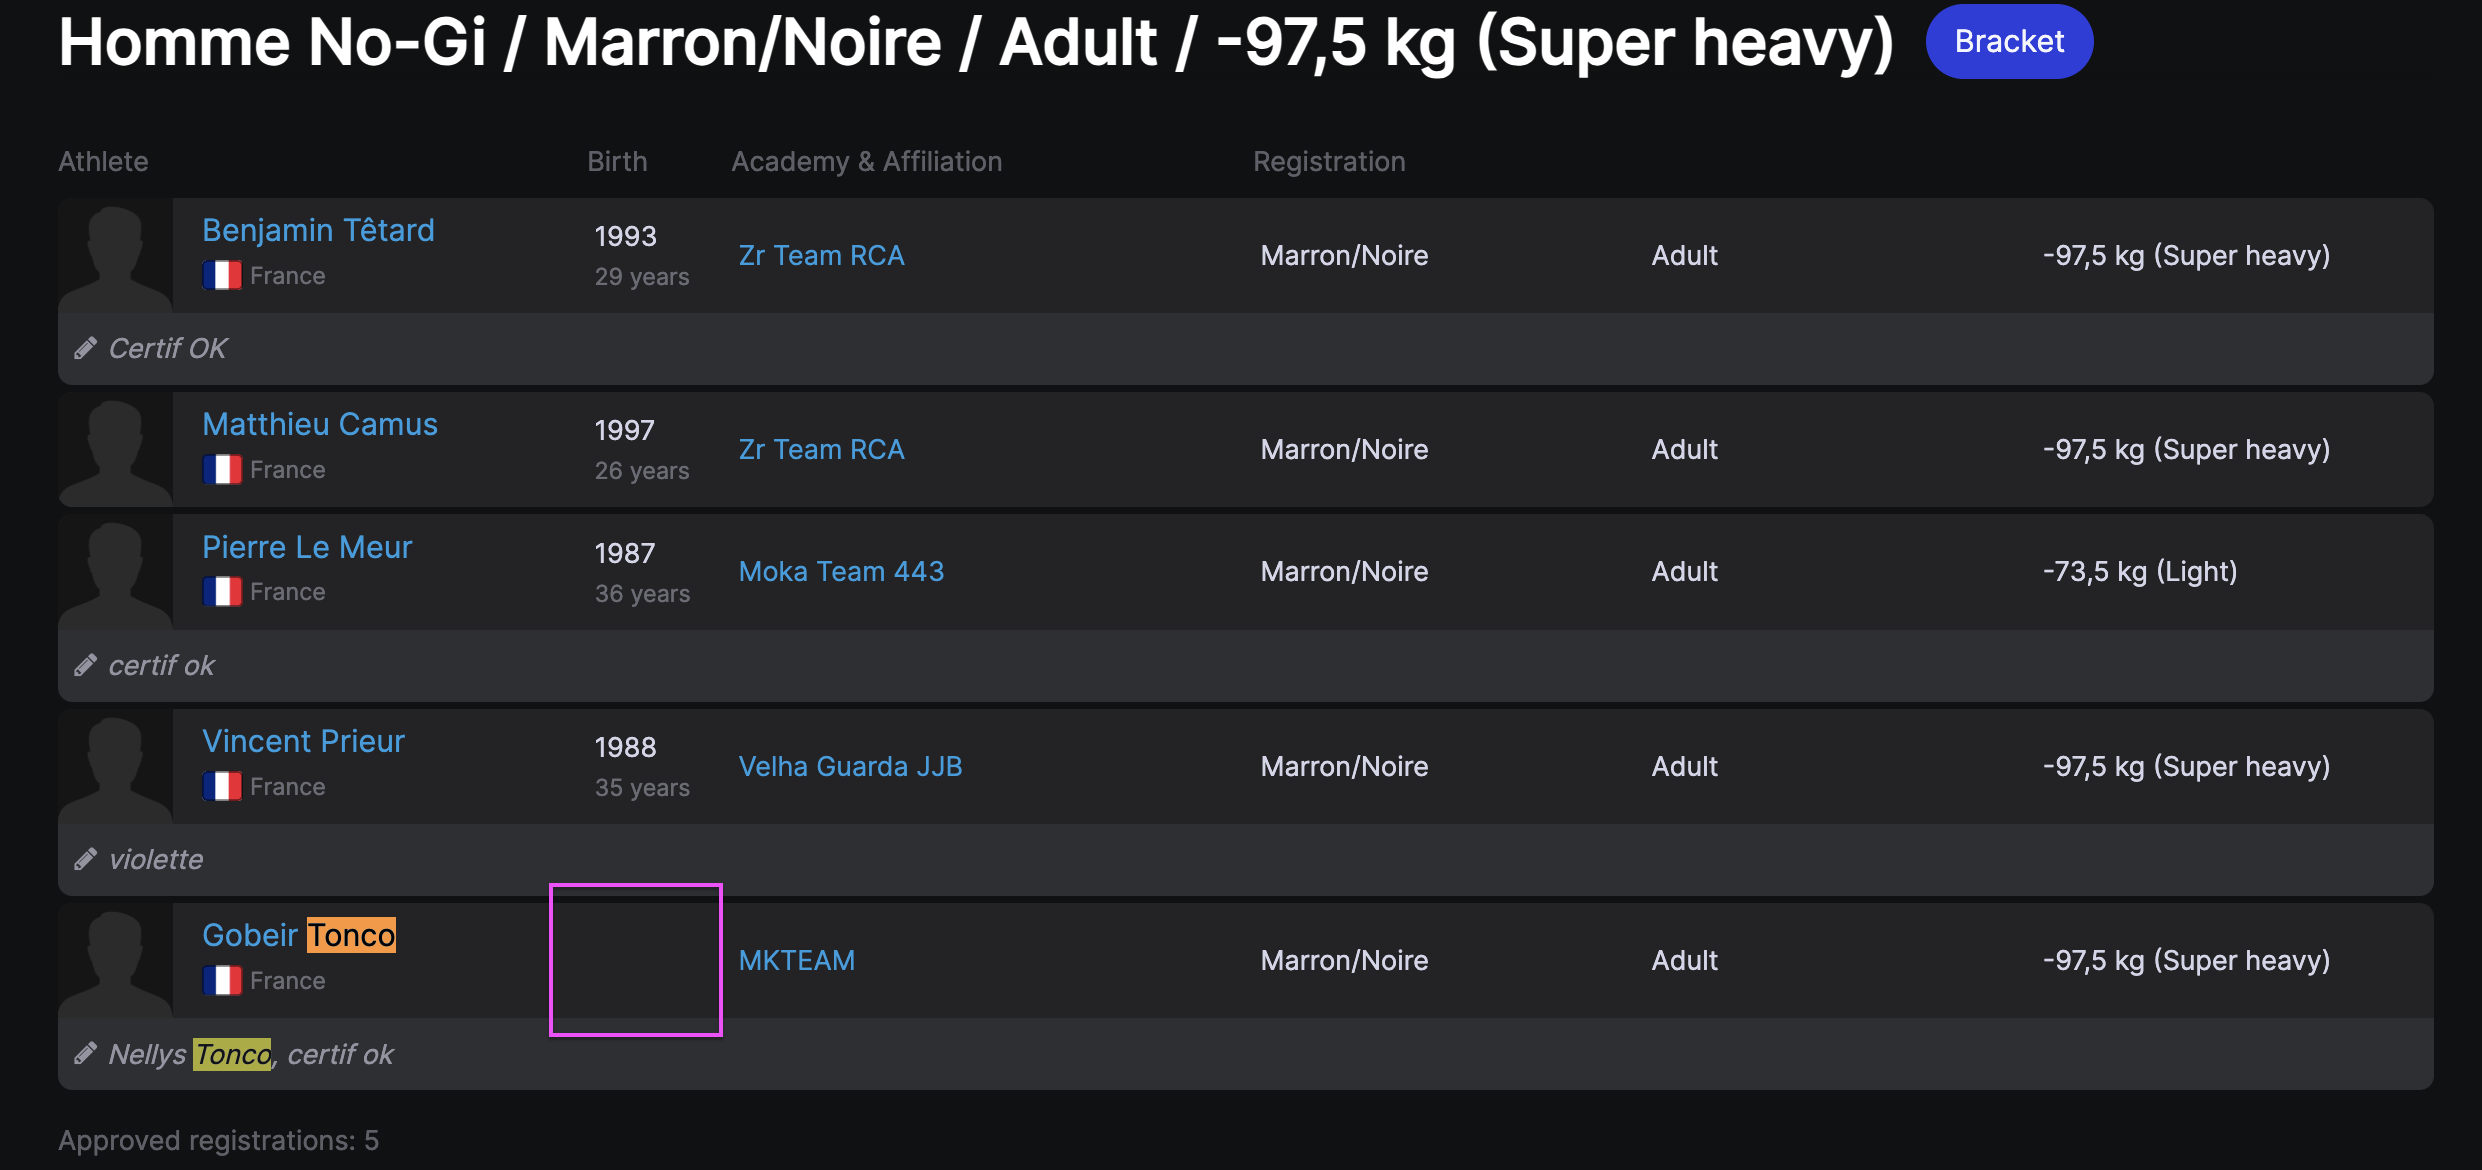

In [190]:
len(nogi_list), len(gi_list)

(33, 31)

In [191]:
df_gi = structure_data(gi_list, 'gi')
df_nogi = structure_data(nogi_list, 'no gi')
df_fighters = pd.concat([df_gi, df_nogi])
df_fighters.reset_index()
df_fighters = df_fighters[['team'
                           , 'nom'
                           , 'type'
                           , 'pays'
                           , 'age'
                           , 'sexe'
                           , 'ceinture'
                           , 'groupe_age'
                           , 'groupe_poids'
                           , 'inscriptions_cate_confirmees'
                           , 'inscriptions_cate_nonconfirmees'
                           , 'snapshot_date'
                          ]
                         ]
df_fighters.sort_values(by = ['snapshot_date', 'team', 'nom', 'type'], inplace = True)
df_fighters.reset_index(inplace = True, drop = True)
mask = (df_fighters['team'].str.startswith('respire')) | (df_fighters['team'].str.startswith('ribeiro'))
display(df_fighters[mask])

,team,nom,type,pays,age,sexe,ceinture,groupe_age,groupe_poids,inscriptions_cate_confirmees,inscriptions_cate_nonconfirmees,snapshot_date
207,respire jiu-jitsu breizh,arnaud eymin,gi,france,34.0,homme,blanche,master 1 (30+),-64 kg (light feather),2,0,2023-11-02
208,respire jiu-jitsu breizh,benoit begasse,gi,france,32.0,homme,blanche,adult,-76 kg (light),18,0,2023-11-02
209,respire jiu-jitsu breizh,benoit begasse,no gi,france,32.0,homme,blanche,adult,"-73,5 kg (light)",19,0,2023-11-02
210,respire jiu-jitsu breizh,félicien de boerdère,gi,france,34.0,homme,blanche,master 1 (30+),"-88,3 kg (medium heavy)",4,0,2023-11-02
211,respire jiu-jitsu breizh,félicien de boerdère,no gi,france,34.0,homme,blanche,master 1 (30+),"-85,5 kg (medium heavy)",4,0,2023-11-02
212,respire jiu-jitsu breizh,guillaume poujol,gi,france,37.0,homme,blanche,master 2 (36+),"-82,3 kg (middle)",2,0,2023-11-02
213,respire jiu-jitsu breizh,hugo kermorvant,gi,france,24.0,homme,blanche,adult,-76 kg (light),18,0,2023-11-02
214,respire jiu-jitsu breizh,hugo kermorvant,no gi,france,24.0,homme,blanche,adult,"-79,5 kg (middle)",25,0,2023-11-02
215,respire jiu-jitsu breizh,julien le garrec,gi,france,32.0,homme,bleue,adult,-76 kg (light),4,0,2023-11-02
216,respire jiu-jitsu breizh,julien le garrec,no gi,france,32.0,homme,bleue,adult,"-73,5 kg (light)",5,0,2023-11-02


Quick checks

In [192]:
df_fighters['team'].value_counts()

zr team rca                               51
yoda fight school                         38
hors normes bjj rennes                    24
moka team 443                             24
mkteam rennes                             20
respire jiu-jitsu breizh                  16
nbjja bdc                                 12
pompomgalli                                9
origine jujitsu                            9
judo plaisir 56                            9
process                                    8
pennarbed jjb                              8
apc29                                      8
ohs lutte & grappling                      7
association lavalloise d’arts martiaux     7
arjjb- bretagne                            7
brazilian sport club                       7
rio de l arrée                             6
icon jiu jitsu team                        6
nostang breizh'il jjb                      5
mb academy                                 4
mkteam                                     4
academie p

In [193]:
df_fighters['groupe_poids'].value_counts()

-70 kg (feather)            36
-79,5 kg (middle)           32
-76 kg (light)              31
-82,3 kg (middle)           24
-73,5 kg (light)            24
-67,5 kg (feather)          24
-64 kg (light feather)      17
-85,5 kg (medium heavy)     16
-61,5 kg (light feather)    13
-94,3 kg (heavy)            10
-88,3 kg (medium heavy)     10
-97,5 kg (super heavy)       9
-66,5 kg (light)             7
-100,5 kg (super heavy)      7
-74,0 kg (middle)            6
-55,5 kg (rooster)           5
-57,5 kg (rooster)           5
+97,5 kg (ultra heavy)       5
-81,5 kg (heavy)             5
-79,3 kg (medium heavy)      4
-56,5 kg (feather)           4
-71,5 kg (middle)            4
-64,0 kg (feather)           4
-66,5 kg (middle)            4
-91,5 kg (heavy)             4
+100,5 kg (ultra heavy)      3
-61,5 kg (feather)           3
-69 kg (heavy)               3
-71,5 kg (middle heavy)      2
-58,5 kg (light feather)     2
-56,5 kg (light feather)     2
Name: groupe_poids, dtype: int64

In [194]:
df_fighters['ceinture'].value_counts()

blanche         222
bleue            75
violette         18
marron/noire     10
Name: ceinture, dtype: int64

In [195]:
df_fighters['age'].value_counts()

26.0    23
21.0    22
18.0    21
23.0    20
20.0    19
24.0    18
16.0    18
19.0    16
25.0    15
17.0    15
15.0    13
22.0    13
28.0    12
34.0    10
29.0    10
31.0     8
33.0     8
32.0     7
30.0     6
37.0     5
38.0     5
36.0     5
35.0     5
46.0     4
43.0     3
27.0     3
40.0     3
44.0     2
52.0     2
53.0     2
41.0     2
50.0     1
39.0     1
48.0     1
42.0     1
45.0     1
51.0     1
55.0     1
49.0     1
47.0     1
Name: age, dtype: int64

Fetch the saved .csv if you want to:

In [144]:
need_import = input('Do you want to import an existing dataframe? (y/n)')

if need_import == 'y':
    df_fighters_import = pd.read_csv('df_fighters.csv')
else:
    df_fighters_import = pd.DataFrame()

Do you want to import an existing dataframe? (y/n)y


In [145]:
display(df_fighters_import.sample(3))

,team,nom,type,pays,age,sexe,ceinture,groupe_age,groupe_poids,inscriptions_cate_confirmees,inscriptions_cate_nonconfirmees,snapshot_date
1237,zr team rca,fred moke,no gi,central african republic,26.0,homme,blanche,adult,"-73,5 kg (light)",20,3,2023-10-29
2397,nbjja bdc,véronique ailloud,no gi,france,46.0,femme,NaN,NaN,NaN,1,0,2023-10-24
2023,yoda fight school,kevin daguene,no gi,france,30.0,homme,blanche,adult,"-67,5 kg (feather)",9,2,2023-10-26


Concatenate with the newly collected data and check we have the right dates:

In [200]:
df_fighters_new = pd.concat([df_fighters, df_fighters_import])
df_fighters_new.reset_index(inplace = True, drop = True)
display(df_fighters_new
        .groupby('snapshot_date', as_index = False)
        .agg({'nom': 'nunique'})
        .rename(columns = {'nom': 'participants'})
        .sort_values(by = 'snapshot_date'))

,snapshot_date,participants
0,2023-10-24,161
1,2023-10-25,176
2,2023-10-26,194
3,2023-10-27,212
4,2023-10-28,236
5,2023-10-29,241
6,2023-10-30,246
7,2023-10-31,251
8,2023-11-01,252
9,2023-11-02,252


Overwrite the .csv with the new data:

In [201]:
df_fighters = df_fighters_new.copy()
df_fighters.to_csv('df_fighters.csv', index = False)

### 2.5. <a name='25'>Visualisations</a>
(<a href='#0'>Go to top</a>)

In [202]:
df = (df_fighters
      .groupby(['team', 'snapshot_date'], as_index = False)
      .agg({'nom': 'nunique'})
      .rename(columns = {'nom': 'participants_confirmes', 'snapshot_date': ' '})
      .pivot(index = 'team', columns = ' ', values = 'participants_confirmes')
      .fillna(0))

latest_date = max(df.columns)
df.sort_values(by = latest_date, ascending = False, inplace = True)
print(f'\nNombre de participants confirmés par équipe au {latest_date}:')
df = df.astype('int')
display(df)


Nombre de participants confirmés par équipe au 2023-11-02:


,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-28,2023-10-29,2023-10-30,2023-10-31,2023-11-01,2023-11-02
team,,,,,,,,,,
zr team rca,22,25,28,31,37,37,39,39,40,39
yoda fight school,20,24,26,26,26,26,27,27,27,27
moka team 443,11,12,11,12,16,16,16,19,20,20
hors normes bjj rennes,12,14,16,17,18,18,19,19,19,19
mkteam rennes,10,13,15,17,17,17,17,17,18,18
nbjja bdc,12,12,12,12,12,12,12,12,12,12
respire jiu-jitsu breizh,4,4,6,7,11,11,11,11,10,10
association lavalloise d’arts martiaux,1,1,3,3,5,5,5,6,7,7
pennarbed jjb,8,8,7,7,7,9,9,9,7,7


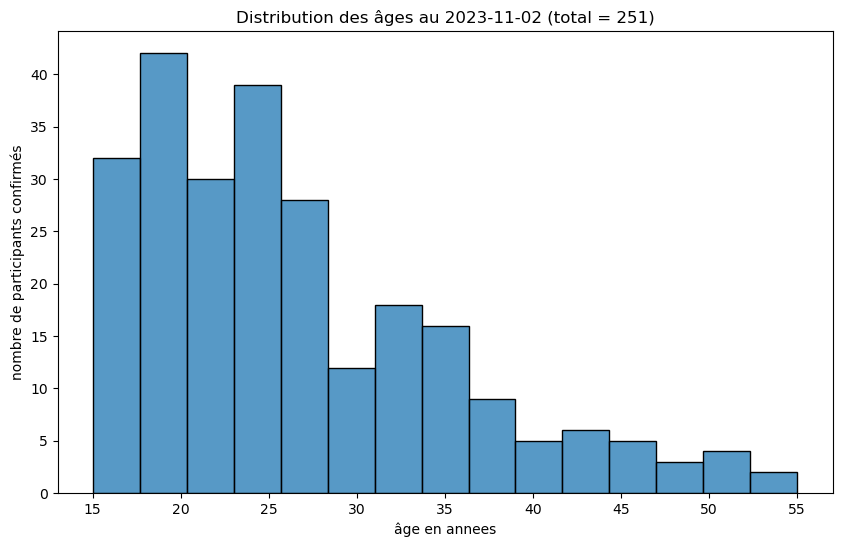

In [203]:
df = (df_fighters[df_fighters['snapshot_date'] == latest_date]
      .groupby(['age'], as_index = False)
      .agg({'nom': 'nunique'})
      .rename(columns = {'nom': 'participants_confirmes'})
     )
n = df['participants_confirmes'].sum()

fig, ax = plt.subplots(figsize = (10, 6))
ax = sns.histplot(data = df, x = 'age', weights = 'participants_confirmes', bins = 15)
ax.set(title = f'Distribution des âges au {latest_date} (total = {n})', xlabel = 'âge en annees', ylabel = 'nombre de participants confirmés')
plt.show()

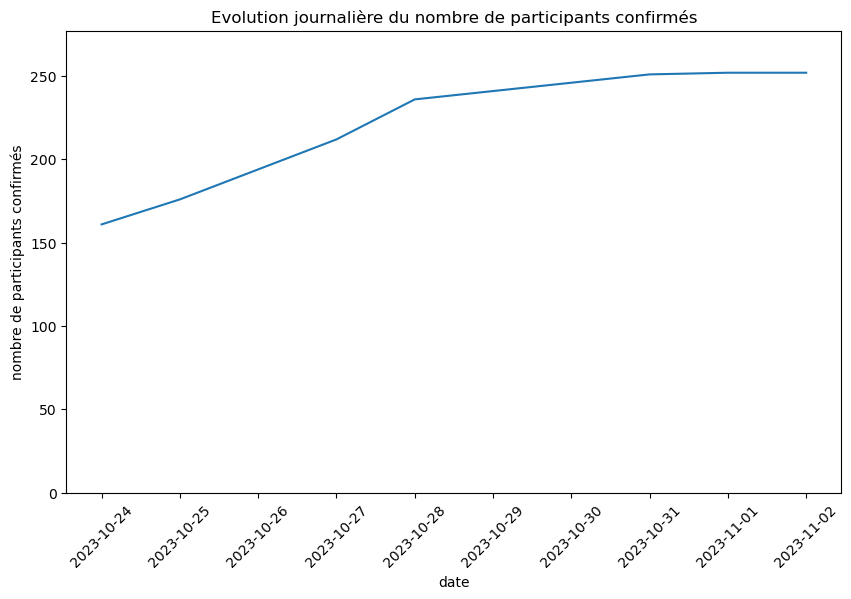

In [205]:
df = (df_fighters
      .groupby('snapshot_date', as_index = False)
      .agg({'nom': 'nunique'})
      .rename(columns = {'nom': 'participants_confirmes', 'snapshot_date': 'date'})
     )

fig, ax = plt.subplots(figsize = (10, 6))
ax = sns.lineplot(data = df, x = 'date', y = 'participants_confirmes')
ax.set(title = f'Evolution journalière du nombre de participants confirmés'
       , xlabel = 'date'
       , ylabel = 'nombre de participants confirmés'
       , ylim = (0, df['participants_confirmes'].max() * 1.1)
      )
plt.xticks(rotation = 45)
plt.show()